In [34]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords , wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer



In [35]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
initial_dataset = pd.read_csv('isear.csv')
initial_dataset.head()

,Emotions,Statements
0,fear,Every time I imagine that someone I love or I ...
1,anger,When I had been obviously unjustly treated and...
2,sadness,When I think about the short time that we live...
3,disgust,At a gathering I found myself involuntarily si...
4,shame,When I realized that I was directing the feeli...


In [37]:
# Fetching all the emotions and it's count present in the dataset
emotions = initial_dataset['Emotions'].value_counts()
print(emotions)
print(f"Total entries in the dataset : {emotions.sum()}")

Emotions
anger      1094
sadness    1094
disgust    1094
shame      1094
fear       1093
guilt      1091
joy        1091
Name: count, dtype: int64
Total entries in the dataset : 7651


In [38]:
# To check if there are any null values present in the dataset
print(initial_dataset.isnull().sum())

Emotions      0
Statements    0
dtype: int64


In [39]:
# To check if there are any duplicate values present in the dataset
print(initial_dataset["Statements"].duplicated().sum())

# Displaying all the duplicates present in the dataset
duplicates = initial_dataset[initial_dataset.duplicated()]

#Print all the unique duplicates present in the dataset
print(duplicates.value_counts())

163
Emotions  Statements                                                                     
shame     [ No response.]                                                                    20
guilt     [ No response.]                                                                    13
disgust   [ No response.]                                                                    12
sadness   [ No response.]                                                                    11
          When my grandfather died.                                                           7
anger     [ No response.]                                                                     7
sadness   When my grandmother died.                                                           5
fear      [ No response.]                                                                     4
shame     Not doing well in the examn.                                                        3
sadness   When my grandmother passed away.

In [40]:
null_responses = ["[ No response.]","[ Do not know.]","NO RESPONSE.","Doesn't apply.","Does not apply.","[ Can not think of anything just now.]" , "[ No description.]" , "[ Never felt the emotion.]" , "[ I have never felt this emotion.]" , "[ Never experienced.]" , "[ Never.]" , "[ Do not remember any incident.]"]

# Removing the rows containing null responses
null_removed_dataset = initial_dataset[~initial_dataset['Statements'].isin(null_responses)]

# To check if there are any null values present in the dataset
print(null_removed_dataset.isnull().sum())

Emotions      0
Statements    0
dtype: int64


In [41]:
# Fetching all the emotions and it's count present in the dataset
updated_emotions = null_removed_dataset['Emotions'].value_counts()
print(updated_emotions)
print(f"Total entries in the dataset : {updated_emotions.sum()}")

Emotions
joy        1087
fear       1085
anger      1084
sadness    1082
disgust    1076
guilt      1067
shame      1063
Name: count, dtype: int64
Total entries in the dataset : 7544


In [42]:
# To check if there are any duplicate values present in the dataset
print(null_removed_dataset["Statements"].duplicated().sum())

# Displaying all the duplicates present in the dataset
updated_duplicates = null_removed_dataset[null_removed_dataset.duplicated()]

#Print all the unique duplicates present in the dataset
print(updated_duplicates.value_counts())

68
Emotions  Statements                                                                     
sadness   When my grandfather died.                                                          7
          When my grandmother died.                                                          5
shame     Not doing well in the examn.                                                       3
sadness   When my grandmother passed away.                                                   3
          When my dog died.                                                                  2
          When my father died.                                                               2
joy       Getting into this university to do medicine.                                       2
          When I was admitted to the University.                                             2
shame     Failing an examn.                                                                  2
fear      Before the examn.                         

In [43]:
print(updated_duplicates)

     Emotions                                         Statements
715   sadness                        When my girlfriend left me.
770   sadness                          When my grandmother died.
1021  sadness                       The death of my grandmother.
1266  sadness                          When my grandfather died.
1345  sadness                When my grandmother died of cancer.
1546  sadness                          When my grandmother died.
2087  sadness                               When my father died.
2277  sadness                          When my grandmother died.
2506  sadness                                  When my dog died.
2548  sadness                          When my grandmother died.
2757  sadness                          When my grandfather died.
2843      joy                              When my son was born.
2899      joy             When I was admitted to the University.
2950      joy             When I was admitted to the University.
4176  sadness            

Emotions
joy        14.408802
fear       14.382291
anger      14.369035
sadness    14.342524
disgust    14.262990
guilt      14.143690
shame      14.090668
Name: count, dtype: float64


<Axes: xlabel='Emotions', ylabel='count'>

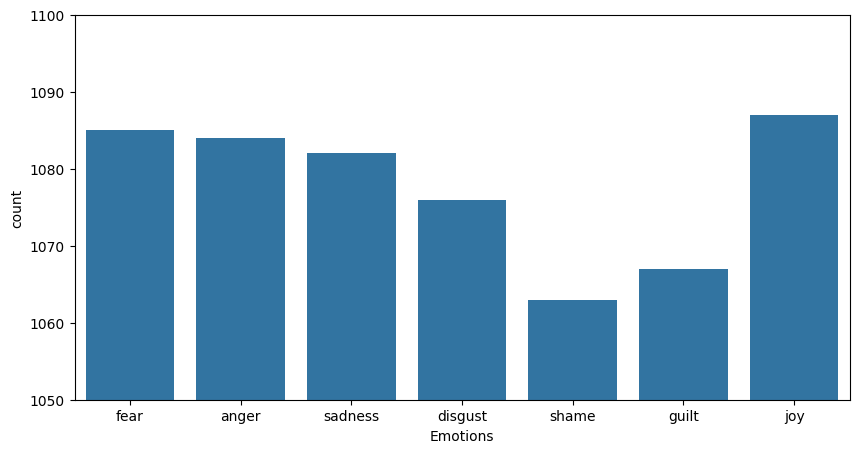

In [44]:
# Percentage of emotions present in the dataset
emotions_percentage = updated_emotions/sum(updated_emotions)*100
print(emotions_percentage)

# Plot the emotions vs it's count as a bar plot and keep the scale of count from 1050 to 1100
plt.figure(figsize=(10,5))
plt.ylim(1050, 1100)
sns.countplot(x='Emotions', data=null_removed_dataset)

In [45]:
# Data Cleaning

def convert_to_lower_case(text):
    return text.lower()

def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_stop_words(text):
    return ' '.join([word for word in str(text).split() if word not in stop_words])

def get_wordnet_pos(word):
    # Map POS tag to first character that the lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)])


def cleaned_sentence(text):
    # text = spell_check(text)
    text = convert_to_lower_case(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_stop_words(text)
    text = lemmatization(text)
    return text



In [46]:
#apply preprocessing to the Statement column
null_removed_dataset['Cleaned_Statements'] = null_removed_dataset['Statements'].apply(cleaned_sentence)

C:\Users\vedan\AppData\Local\Temp\ipykernel_42548\1100354829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_removed_dataset['Cleaned_Statements'] = null_removed_dataset['Statements'].apply(cleaned_sentence)


In [47]:
#label encoding for emotions
label_encoder = LabelEncoder()
null_removed_dataset['Encoded_Emotion'] = label_encoder.fit_transform(null_removed_dataset['Emotions'])

C:\Users\vedan\AppData\Local\Temp\ipykernel_42548\1078975077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_removed_dataset['Encoded_Emotion'] = label_encoder.fit_transform(null_removed_dataset['Emotions'])


In [48]:
#tokenizing words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(null_removed_dataset['Cleaned_Statements'])
X = tokenizer.texts_to_sequences(null_removed_dataset['Cleaned_Statements'])
X = pad_sequences(X)

In [49]:
# train test split stuff
X_train, X_test, y_train, y_test = train_test_split(X, null_removed_dataset['Encoded_Emotion'], test_size=0.2, random_state=42)

In [50]:
#build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128))
model.add(LSTM(units=128))
model.add(Dense(units=len(null_removed_dataset['Emotions'].unique()), activation='softmax'))

In [51]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
#train the dude
model.fit(X_train, y_train, batch_size=64, epochs=16, validation_data=(X_test, y_test))

Epoch 1/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.2339 - loss: 1.9108 - val_accuracy: 0.4248 - val_loss: 1.5928
Epoch 2/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.5925 - loss: 1.2501 - val_accuracy: 0.5507 - val_loss: 1.2481
Epoch 3/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7603 - loss: 0.7504 - val_accuracy: 0.5573 - val_loss: 1.2563
Epoch 4/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.8477 - loss: 0.4939 - val_accuracy: 0.5480 - val_loss: 1.4561
Epoch 5/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8908 - loss: 0.3571 - val_accuracy: 0.5414 - val_loss: 1.5163
Epoch 6/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.9201 - loss: 0.2744 - val_accuracy: 0.5302 - val_loss: 1.7119
Epoch 7/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9344 - loss: 0.2139 - val_accuracy: 0.5262 - val_loss: 1.8683
Epoch 8/16
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9546 - loss: 0.1620 - val_accur

In [53]:
#predict sentiment/emotion
def predict_sentiment(sentence):
    cleaned_sentences = cleaned_sentence(sentence)
    tokenized_sentence = tokenizer.texts_to_sequences([cleaned_sentences])
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=X.shape[1])
    predicted_emotion = label_encoder.inverse_transform([np.argmax(model.predict(padded_sentence))])[0]
    return predicted_emotion

In [54]:
input = "I stare at the blank wall"

predicted_emotion = predict_sentiment(input)
print(f"Sentence: {input}\nPredicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Sentence: I stare at the blank wall
Predicted Emotion: fear
